In [2]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

import numpy as np
import pandas as pd
import pandas_datareader.data as web

from statsmodels.regression.rolling import RollingOLS
import statsmodels.api as sm
from talib import RSI, BBANDS, MACD, NATR, ATR

from sklearn.feature_selection import mutual_info_classif, mutual_info_regression

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
idx = pd.IndexSlice

In [3]:
DATA_STORE = 'data/assets.h5'
YEAR = 12
START = 1995
END = 2017
with pd.HDFStore(DATA_STORE) as store:
    prices = (store['quandl/wiki/prices'].loc[idx[str(START):str(END), :], :]
              .filter(like='adj_').dropna().swaplevel().rename(columns=lambda x: x.replace('adj_', ''))
              .join(store['us_equities/stocks'].loc[:, ['sector']]).dropna())
prices.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10241831 entries, ('AAN', Timestamp('1995-01-03 00:00:00')) to ('ZUMZ', Timestamp('2017-12-29 00:00:00'))
Data columns (total 6 columns):
 #   Column  Non-Null Count     Dtype  
---  ------  --------------     -----  
 0   open    10241831 non-null  float64
 1   high    10241831 non-null  float64
 2   low     10241831 non-null  float64
 3   close   10241831 non-null  float64
 4   volume  10241831 non-null  float64
 5   sector  10241831 non-null  object 
dtypes: float64(5), object(1)
memory usage: 508.7+ MB


In [4]:
len(prices.index.unique('ticker'))

2369

In [5]:
min_obs = 10 * 252
nobs = prices.groupby(level='ticker').size()
to_drop = nobs[nobs < min_obs].index
prices = prices.drop(to_drop, level='ticker')
prices.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 9532628 entries, ('AAN', Timestamp('1995-01-03 00:00:00')) to ('ZUMZ', Timestamp('2017-12-29 00:00:00'))
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   open    9532628 non-null  float64
 1   high    9532628 non-null  float64
 2   low     9532628 non-null  float64
 3   close   9532628 non-null  float64
 4   volume  9532628 non-null  float64
 5   sector  9532628 non-null  object 
dtypes: float64(5), object(1)
memory usage: 473.5+ MB


In [6]:
len(prices.index.unique('ticker'))

1883

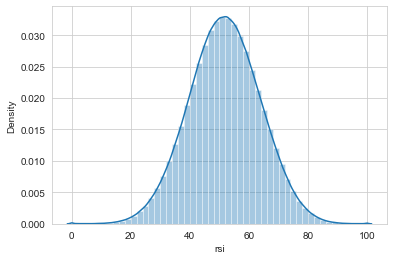

In [7]:
prices['rsi'] = prices.groupby(level='ticker').close.apply(RSI) # relative strength index
sns.distplot(prices.rsi);

In [8]:
# Bollinger Bands
def compute_bb(close):
    high, mid, low = BBANDS(np.log1p(close), timeperiod=20)
    return pd.DataFrame({'bb_high': high, 'bb_mid': mid, 'bb_low': low}, index=close.index)
prices = (prices.join(prices.groupby(level='ticker').close.apply(compute_bb)))
prices.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 9532628 entries, ('AAN', Timestamp('1995-01-03 00:00:00')) to ('ZUMZ', Timestamp('2017-12-29 00:00:00'))
Data columns (total 10 columns):
 #   Column   Non-Null Count    Dtype  
---  ------   --------------    -----  
 0   open     9532628 non-null  float64
 1   high     9532628 non-null  float64
 2   low      9532628 non-null  float64
 3   close    9532628 non-null  float64
 4   volume   9532628 non-null  float64
 5   sector   9532628 non-null  object 
 6   rsi      9506266 non-null  float64
 7   bb_high  9496851 non-null  float64
 8   bb_mid   9496851 non-null  float64
 9   bb_low   9496851 non-null  float64
dtypes: float64(9), object(1)
memory usage: 1022.4+ MB


In [9]:
prices.tail()

,,open,high,low,close,volume,sector,rsi,bb_high,bb_mid,bb_low
ticker,date,,,,,,,,,,
ZEUS,2017-12-29,21.76,21.9600,21.47,21.490,39215.0,Basic Industries,54.357447,3.168421,3.110019,3.051617
ZION,2017-12-29,51.28,51.5500,50.81,50.830,1258353.0,Finance,57.076071,3.968271,3.943971,3.919671
ZIOP,2017-12-29,4.00,4.2800,3.98,4.140,2995165.0,Health Care,44.348071,1.710400,1.654014,1.597628
ZIXI,2017-12-29,4.42,4.4962,4.38,4.380,185621.0,Technology,45.400332,1.724550,1.684437,1.644325
ZUMZ,2017-12-29,21.25,21.4500,20.80,20.825,222040.0,Consumer Services,52.959469,3.135397,3.088436,3.041474


In [10]:
prices.filter(like='bb_').describe()

,bb_high,bb_mid,bb_low
count,9.496851e+06,9.496851e+06,9.496851e+06
mean,2.954140e+00,2.881157e+00,2.808174e+00
std,1.024536e+00,1.026901e+00,1.032999e+00
min,8.933146e-03,8.933146e-03,-1.568426e+00
25%,2.303724e+00,2.226078e+00,2.146471e+00
50%,2.940911e+00,2.868116e+00,2.796484e+00
75%,3.555602e+00,3.487039e+00,3.420498e+00
max,1.376991e+01,1.358056e+01,1.346225e+01


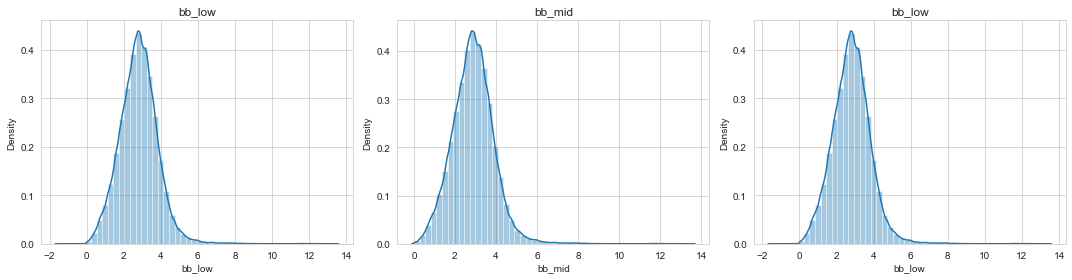

In [11]:
fig, axes = plt.subplots(ncols=3, figsize=(15,4))
for i, col in enumerate(['bb_low', 'bb_mid', 'bb_low']):
    sns.distplot(prices[col], ax=axes[i])
    axes[i].set_title(col)
fig.tight_layout()

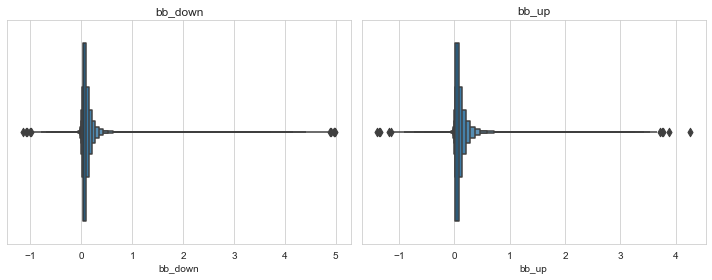

In [12]:
prices['bb_up'] = prices.bb_high.sub(np.log1p(prices.close))
prices['bb_down'] = np.log1p(prices.close).sub(prices.bb_low)
fig, axes = plt.subplots(ncols=2, figsize=(10,4))
for i, col in enumerate(['bb_down', 'bb_up']):
    sns.boxenplot(prices[col], ax=axes[i])
    axes[i].set_title(col)
fig.tight_layout()

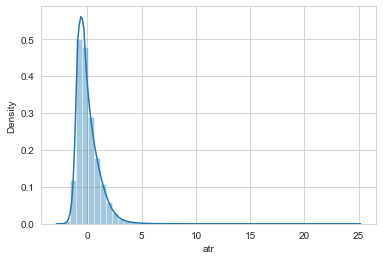

In [13]:
# Average True Range (Volatility Indicators)
by_ticker = prices.groupby('ticker', group_keys=False)
def compute_atr(stock_data):
    atr = ATR(stock_data.high, stock_data.low, stock_data.close, timeperiod=14)
    return atr.sub(atr.mean()).div(atr.std())
prices['atr'] = by_ticker.apply(compute_atr)
sns.distplot(prices.atr);

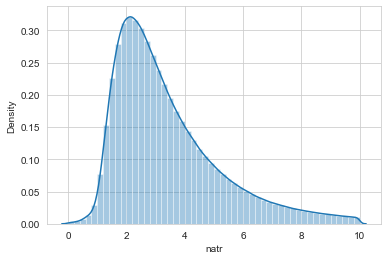

In [14]:
# NATR: Normalized Average True Range (Volatility Indicators)
prices['natr'] = by_ticker.apply(lambda x: NATR(high=x.high, low=x.low, close=x.close))
sns.distplot(prices.natr[prices.natr<10]);

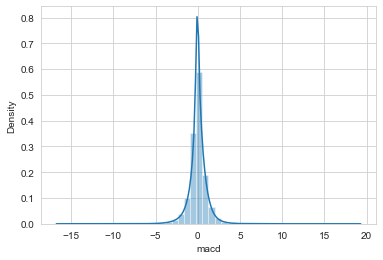

In [15]:
# Moving Average Convergence/Divergence
def compute_macd(close):
    macd = MACD(close)[0]
    return macd.sub(macd.mean()).div(macd.std())

prices['macd'] = prices.groupby(level='ticker').close.apply(compute_macd)
sns.distplot(prices.macd);

In [16]:
# Compute dollar volume to determine universe
prices['dollar_volume'] = (prices.loc[:, 'close'].mul(prices.loc[:, 'volume'], axis=0))

prices.dollar_volume /= 1e6
prices.to_hdf('data/data.h5', 'us/equities/prices')
prices = pd.read_hdf('data/data.h5', 'us/equities/prices')
prices.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 9532628 entries, ('AAN', Timestamp('1995-01-03 00:00:00')) to ('ZUMZ', Timestamp('2017-12-29 00:00:00'))
Data columns (total 16 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   open           9532628 non-null  float64
 1   high           9532628 non-null  float64
 2   low            9532628 non-null  float64
 3   close          9532628 non-null  float64
 4   volume         9532628 non-null  float64
 5   sector         9532628 non-null  object 
 6   rsi            9506266 non-null  float64
 7   bb_high        9496851 non-null  float64
 8   bb_mid         9496851 non-null  float64
 9   bb_low         9496851 non-null  float64
 10  bb_up          9496851 non-null  float64
 11  bb_down        9496851 non-null  float64
 12  atr            9506266 non-null  float64
 13  natr           9506266 non-null  float64
 14  macd           9470489 non-null  float64
 15  dollar_volume  9532628 no

In [17]:
last_cols = [c for c in prices.columns.unique(0) if c not in ['dollar_volume', 'volume', 'open', 'high', 'low']]
prices = prices.unstack('ticker')
# Monthly resample OHLCV prices
data = (pd.concat([prices.dollar_volume.resample('M').mean().stack('ticker').to_frame('dollar_volume'),
                   prices[last_cols].resample('M').last().stack('ticker')], axis=1).swaplevel().dropna())
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 452529 entries, ('AAN', Timestamp('1995-02-28 00:00:00')) to ('ORN', Timestamp('2017-12-31 00:00:00'))
Data columns (total 12 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   dollar_volume  452529 non-null  float64
 1   atr            452529 non-null  float64
 2   bb_down        452529 non-null  float64
 3   bb_high        452529 non-null  float64
 4   bb_low         452529 non-null  float64
 5   bb_mid         452529 non-null  float64
 6   bb_up          452529 non-null  float64
 7   close          452529 non-null  float64
 8   macd           452529 non-null  float64
 9   natr           452529 non-null  float64
 10  rsi            452529 non-null  float64
 11  sector         452529 non-null  object 
dtypes: float64(11), object(1)
memory usage: 43.2+ MB


In [39]:
data.tail()

atr   bb_down   bb_high    bb_low    bb_mid     bb_up  \
ticker date                                                                     
ZION   2017-07-31 -0.181012  0.038654  3.841345  3.794321  3.817833  0.008370   
       2017-08-31 -0.274439  0.013926  3.849378  3.785152  3.817265  0.050299   
       2017-09-30 -0.155049  0.139050  3.884183  3.735894  3.810038  0.009239   
       2017-10-31 -0.134904  0.016495  3.889834  3.843392  3.866613  0.029946   
       2017-11-30  0.125608  0.120711  3.918737  3.802252  3.860494 -0.004226   

                       macd      natr        rsi   sector  ...       RMW  \
ticker date                                                ...             
ZION   2017-07-31  0.657033  1.885520  62.089693  Finance  ... -0.952888   
       2017-08-31 -0.259812  1.804202  43.528169  Finance  ... -0.956016   
       2017-09-30  0.876060  1.844395  70.270187  Finance  ... -0.981499   
       2017-10-31  0.270798  1.902929  51.467907  Finance  ... -0.948183   
       2017-11-30  0.698692  2.147435  69.398587  Finance  ... -1.022824   

                        CMA  momentum_3  momentum_6  momentum_3_6  \
ticker date                                                         
ZION   2017-07-31 -1.804549    0.010813   -0.019481     -0.030294   
       2017-08-31 -1.796359    0.063992    0.030177     -0.033815   
       2017-09-30 -1.779831   -0.055484   -0.060265     -0.004781   
       2017-10-31 -1.839045    0.024469    0.041188      0.016719   
       2017-11-30 -1.445504   -0.023423   -0.030024     -0.006601   

                   momentum_12  momentum_3_12  year  month    target  
ticker date                                                           
ZION   2017-07-31     0.009953      -0.000859  2017      7 -0.034067  
       2017-08-31     0.064885       0.000892  2017      8  0.080623  
       2017-09-30    -0.044329       0.011155  2017      9 -0.015261  
       2017-10-31     0.046986       0.022517  2017     10  0.066509  
       2017-11-30    -0.047517      -0.024094  2017     11  0.025832  

[5 rows x 27 columns]

In [18]:
data['dollar_volume'] = (data.loc[:, 'dollar_volume'].unstack('ticker').rolling(window=5*12, min_periods=12)
                         .mean().stack().swaplevel())
data['dollar_vol_rank'] = (data.groupby('date').dollar_volume.rank(ascending=False))

# Select 500 most-traded equities
data = data[data.dollar_vol_rank < 500].drop(['dollar_volume', 'dollar_vol_rank'], axis=1)
len(data.index.unique('ticker'))

905

In [40]:
data.describe()

,atr,bb_down,bb_high,bb_low,bb_mid,bb_up,macd,natr,rsi,return_1m,...,RMW,CMA,momentum_3,momentum_6,momentum_3_6,momentum_12,momentum_3_12,year,month,target
count,77788.000000,77788.000000,77788.000000,77788.000000,77788.000000,77788.000000,77788.000000,77788.000000,77788.000000,77788.000000,...,77788.000000,77788.000000,77788.000000,77788.000000,77788.000000,77788.000000,77788.000000,77788.000000,77788.000000,77788.000000
mean,0.203867,0.063473,3.554041,3.433821,3.493931,0.056747,0.017577,2.844165,52.181190,0.009907,...,-0.017799,0.006418,-0.002509,-0.003163,-0.000653,-0.003682,-0.001173,2009.828213,6.483854,0.009969
std,0.932896,0.065121,0.784633,0.808042,0.794984,0.070509,1.050561,1.953674,11.452529,0.090970,...,0.877750,0.966550,0.075866,0.083865,0.038477,0.088416,0.048414,4.590917,3.436954,0.090780
min,-2.100992,-0.340068,0.130989,-0.022047,0.111462,-0.258509,-11.731808,0.211689,7.051405,-0.273767,...,-5.199960,-5.129024,-0.510674,-0.465352,-0.314910,-0.425050,-0.274609,2002.000000,1.000000,-0.273767
25%,-0.461676,0.023108,3.052478,2.922112,2.989039,0.017070,-0.486613,1.753134,44.259274,-0.038143,...,-0.492989,-0.543407,-0.039331,-0.043313,-0.019600,-0.046497,-0.024611,2006.000000,3.000000,-0.037912
50%,-0.020106,0.047362,3.545633,3.428672,3.487401,0.036802,0.028463,2.330652,52.330847,0.010685,...,0.046043,0.056376,0.001704,0.000766,0.001103,-0.000735,0.000292,2010.000000,6.000000,0.010683
75%,0.668124,0.084364,4.032170,3.930924,3.981591,0.072447,0.556330,3.277343,60.143693,0.057658,...,0.538238,0.598919,0.039891,0.044069,0.020939,0.045108,0.025010,2014.000000,9.000000,0.057579
max,9.000308,1.503232,7.089264,6.990442,7.039492,2.435809,8.883025,64.788136,93.022157,0.331175,...,4.036887,5.085621,0.454501,0.404937,0.265895,0.373494,0.264625,2017.000000,12.000000,0.331175


In [19]:
# Create monthly return series
outlier_cutoff = 0.01
lags = [1, 3, 6, 12]
returns = []
for lag in lags:
    returns.append(data.close.unstack('ticker').sort_index().pct_change(lag).stack('ticker')
                   .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),upper=x.quantile(1-outlier_cutoff)))
                   .add(1).pow(1/lag).sub(1).to_frame(f'return_{lag}m'))

returns = pd.concat(returns, axis=1).swaplevel()
returns.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 202879 entries, ('AAPL', Timestamp('1996-02-29 00:00:00')) to ('DXCM', Timestamp('2017-12-31 00:00:00'))
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   return_1m   202879 non-null  float64
 1   return_3m   201069 non-null  float64
 2   return_6m   198362 non-null  float64
 3   return_12m  192972 non-null  float64
dtypes: float64(4)
memory usage: 7.0+ MB


In [20]:
returns.describe()

,return_1m,return_3m,return_6m,return_12m
count,202879.000000,201069.000000,198362.000000,192972.000000
mean,0.007333,0.004950,0.004345,0.004167
std,0.085992,0.050986,0.037222,0.027246
min,-0.273767,-0.179499,-0.134177,-0.093876
25%,-0.011852,-0.003188,-0.000486,0.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,0.032949,0.023727,0.018920,0.015461
max,0.331175,0.180733,0.131169,0.099726


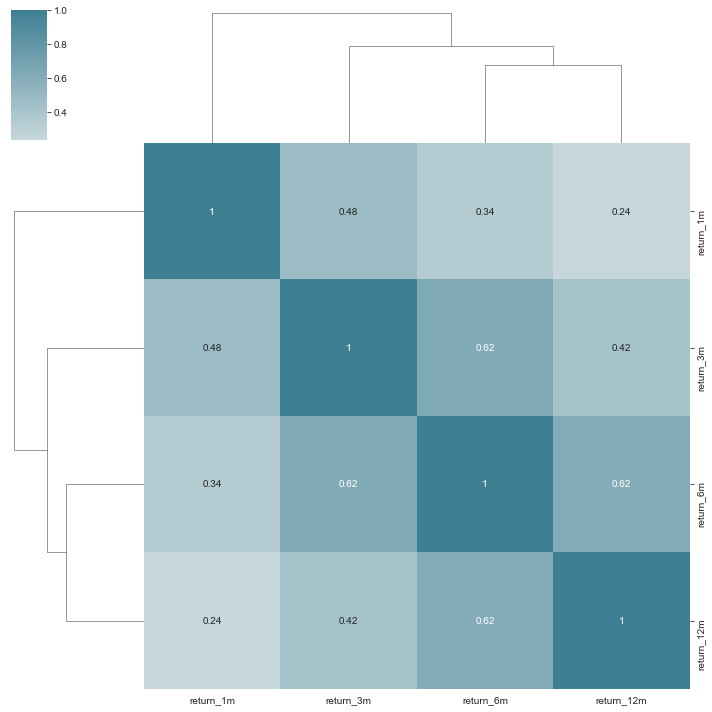

In [21]:
cmap = sns.diverging_palette(10, 220, as_cmap=True)
sns.clustermap(returns.corr('spearman'), annot=True, center=0, cmap=cmap);

In [22]:
data = data.join(returns).drop('close', axis=1).dropna()
data.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 121589 entries, ('AAPL', Timestamp('1997-01-31 00:00:00')) to ('ULTA', Timestamp('2017-12-31 00:00:00'))
Data columns (total 14 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   atr         121589 non-null  float64
 1   bb_down     121589 non-null  float64
 2   bb_high     121589 non-null  float64
 3   bb_low      121589 non-null  float64
 4   bb_mid      121589 non-null  float64
 5   bb_up       121589 non-null  float64
 6   macd        121589 non-null  float64
 7   natr        121589 non-null  float64
 8   rsi         121589 non-null  float64
 9   sector      121589 non-null  object 
 10  return_1m   121589 non-null  float64
 11  return_3m   121589 non-null  float64
 12  return_6m   121589 non-null  float64
 13  return_12m  121589 non-null  float64
dtypes: float64(13), object(1)
memory usage: 13.5+ MB


In [23]:
min_obs = 5*12
nobs = data.groupby(level='ticker').size()
to_drop = nobs[nobs < min_obs].index
data = data.drop(to_drop, level='ticker')
len(data.index.unique('ticker'))

613

In [24]:
# Rolling Factor Betas
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3', 'famafrench', start=START)[0].drop('RF', axis=1)
factor_data.index = factor_data.index.to_timestamp()
factor_data = factor_data.resample('M').last().div(100)
factor_data.index.name = 'date'
factor_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 339 entries, 1995-01-31 to 2023-03-31
Freq: M
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Mkt-RF  339 non-null    float64
 1   SMB     339 non-null    float64
 2   HML     339 non-null    float64
 3   RMW     339 non-null    float64
 4   CMA     339 non-null    float64
dtypes: float64(5)
memory usage: 15.9 KB


In [25]:
factor_data = factor_data.join(data['return_1m']).dropna().sort_index()
factor_data['return_1m'] -= factor_data['Mkt-RF']
factor_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 115181 entries, ('A', Timestamp('2001-12-31 00:00:00', freq='M')) to ('ZION', Timestamp('2017-12-31 00:00:00', freq='M'))
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Mkt-RF     115181 non-null  float64
 1   SMB        115181 non-null  float64
 2   HML        115181 non-null  float64
 3   RMW        115181 non-null  float64
 4   CMA        115181 non-null  float64
 5   return_1m  115181 non-null  float64
dtypes: float64(6)
memory usage: 5.8+ MB


In [49]:
factor_data.describe()

,Mkt-RF,SMB,HML,RMW,CMA,return_1m
count,115181.000000,115181.000000,115181.000000,115181.000000,115181.000000,115181.000000
mean,0.006182,0.002322,0.001869,0.003279,0.002459,0.005458
std,0.044295,0.031620,0.031330,0.029362,0.020980,0.092551
min,-0.172300,-0.153500,-0.112900,-0.187300,-0.067700,-0.387267
25%,-0.019700,-0.017000,-0.014900,-0.010700,-0.010300,-0.043905
50%,0.011700,0.001400,0.000300,0.003600,0.000100,0.002599
75%,0.034900,0.023300,0.017800,0.013900,0.014300,0.050718
max,0.113500,0.183400,0.124800,0.130900,0.090500,0.503475


In [27]:
T = 60
# RollingOLSL calculate the minimized vector of RSS(residual sum of squares) with fixed windows of observations
betas = (factor_data.groupby(level='ticker', group_keys=False)
         .apply(lambda x: RollingOLS(endog=x.return_1m, exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                     window=min(T, x.shape[0]-1))
                .fit(params_only=True).params.rename(columns={'Mkt-RF': 'beta'}).drop('const', axis=1)))
betas.describe().join(betas.sum(1).describe().to_frame('total'))

,beta,SMB,HML,RMW,CMA,total
count,79014.000000,79014.000000,79014.000000,79014.000000,79014.000000,115181.000000
mean,0.066598,0.188692,0.117500,-0.018823,0.009464,0.249313
std,0.480192,0.586570,0.819290,0.878633,0.968526,1.384273
min,-1.841482,-1.996306,-4.042187,-5.199960,-5.129024,-10.004624
25%,-0.257032,-0.206774,-0.414341,-0.495432,-0.543073,-0.143132
50%,0.044421,0.147280,0.062184,0.044692,0.058272,0.000000
75%,0.370251,0.544059,0.603406,0.537274,0.603466,0.838982
max,2.739554,3.314653,4.759474,4.036887,5.085621,10.772196


In [28]:
betas.describe().join(betas.sum(1).describe().to_frame('total'))

,beta,SMB,HML,RMW,CMA,total
count,79014.000000,79014.000000,79014.000000,79014.000000,79014.000000,115181.000000
mean,0.066598,0.188692,0.117500,-0.018823,0.009464,0.249313
std,0.480192,0.586570,0.819290,0.878633,0.968526,1.384273
min,-1.841482,-1.996306,-4.042187,-5.199960,-5.129024,-10.004624
25%,-0.257032,-0.206774,-0.414341,-0.495432,-0.543073,-0.143132
50%,0.044421,0.147280,0.062184,0.044692,0.058272,0.000000
75%,0.370251,0.544059,0.603406,0.537274,0.603466,0.838982
max,2.739554,3.314653,4.759474,4.036887,5.085621,10.772196


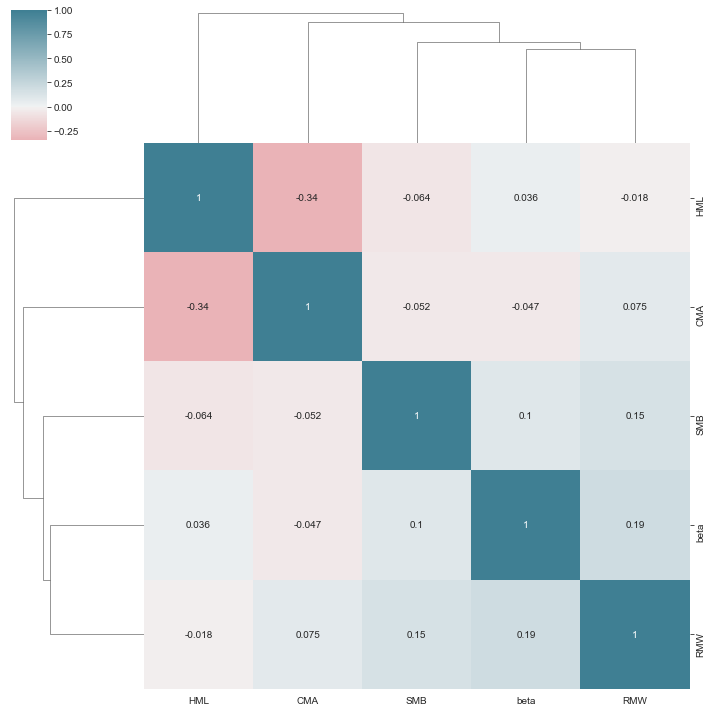

In [29]:
cmap = sns.diverging_palette(10, 220, as_cmap=True)
sns.clustermap(betas.corr(), annot=True, cmap=cmap, center=0);

In [30]:
data = (data.join(betas.groupby(level='ticker').shift()).dropna().sort_index())
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 78401 entries, ('A', Timestamp('2006-12-31 00:00:00')) to ('ZION', Timestamp('2017-12-31 00:00:00'))
Data columns (total 19 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   atr         78401 non-null  float64
 1   bb_down     78401 non-null  float64
 2   bb_high     78401 non-null  float64
 3   bb_low      78401 non-null  float64
 4   bb_mid      78401 non-null  float64
 5   bb_up       78401 non-null  float64
 6   macd        78401 non-null  float64
 7   natr        78401 non-null  float64
 8   rsi         78401 non-null  float64
 9   sector      78401 non-null  object 
 10  return_1m   78401 non-null  float64
 11  return_3m   78401 non-null  float64
 12  return_6m   78401 non-null  float64
 13  return_12m  78401 non-null  float64
 14  beta        78401 non-null  float64
 15  SMB         78401 non-null  float64
 16  HML         78401 non-null  float64
 17  RMW         78401 non-null  floa

In [31]:
for lag in [3, 6, 12]:
    data[f'momentum_{lag}'] = data[f'return_{lag}m'].sub(data.return_1m)
    if lag > 3:
        data[f'momentum_3_{lag}'] = data[f'return_{lag}m'].sub(data.return_3m)

In [32]:
# Date Indicators
dates = data.index.get_level_values('date')
data['year'] = dates.year
data['month'] = dates.month

In [33]:
# Target: Holding Period Returns
data['target'] = data.groupby(level='ticker')[f'return_1m'].shift(-1)
data = data.dropna()
data.sort_index().info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 77788 entries, ('A', Timestamp('2006-12-31 00:00:00')) to ('ZION', Timestamp('2017-11-30 00:00:00'))
Data columns (total 27 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   atr            77788 non-null  float64
 1   bb_down        77788 non-null  float64
 2   bb_high        77788 non-null  float64
 3   bb_low         77788 non-null  float64
 4   bb_mid         77788 non-null  float64
 5   bb_up          77788 non-null  float64
 6   macd           77788 non-null  float64
 7   natr           77788 non-null  float64
 8   rsi            77788 non-null  float64
 9   sector         77788 non-null  object 
 10  return_1m      77788 non-null  float64
 11  return_3m      77788 non-null  float64
 12  return_6m      77788 non-null  float64
 13  return_12m     77788 non-null  float64
 14  beta           77788 non-null  float64
 15  SMB            77788 non-null  float64
 16  HML            7778

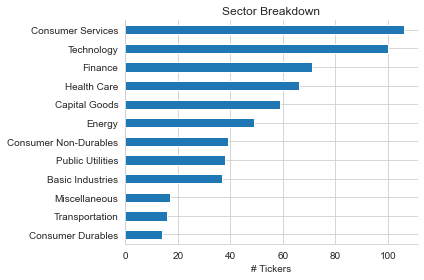

In [34]:
# Sector Breakdown
ax = data.reset_index().groupby('sector').ticker.nunique().sort_values().plot.barh(title='Sector Breakdown')
ax.set_ylabel('')
ax.set_xlabel('# Tickers')
sns.despine()
plt.tight_layout();

In [35]:
with pd.HDFStore('data/data.h5') as store:
    store.put('us/equities/monthly', data)

In [36]:
# Evaluate mutual information
X = data.drop('target', axis=1)
X.sector = pd.factorize(X.sector)[0]
mi = mutual_info_regression(X=X, y=data.target)
mi_reg = pd.Series(mi, index=X.columns)
mi_reg.nlargest(10)

natr             0.111765
return_12m       0.059981
return_6m        0.054473
year             0.049260
return_3m        0.047178
momentum_3_12    0.040457
momentum_3_6     0.038277
bb_up            0.035960
momentum_12      0.035785
return_1m        0.034865
dtype: float64

In [37]:
mi = mutual_info_classif(X=X, y=(data.target>0).astype(int))
mi_class = pd.Series(mi, index=X.columns)
mi_class.nlargest(10)

year          0.010618
month         0.009057
return_6m     0.005531
sector        0.005313
atr           0.005069
rsi           0.004230
return_12m    0.003511
natr          0.001928
return_1m     0.001916
beta          0.001615
dtype: float64

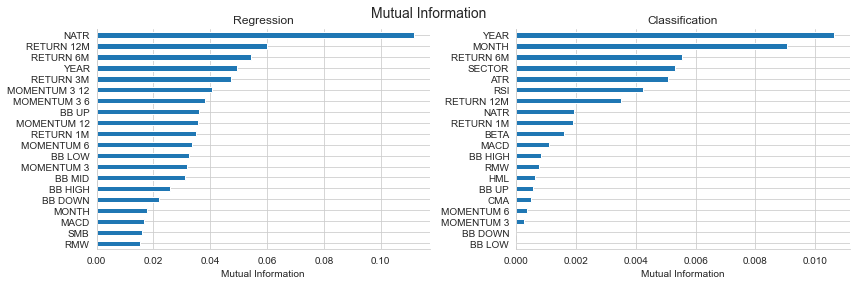

In [38]:
mi = mi_reg.to_frame('Regression').join(mi_class.to_frame('Classification'))
mi.index = [' '.join(c.upper().split('_')) for c in mi.index]
fig, axes = plt.subplots(ncols=2, figsize=(12, 4))
for i, t in enumerate(['Regression', 'Classification']):
    mi[t].nlargest(20).sort_values().plot.barh(title=t, ax=axes[i])
    axes[i].set_xlabel('Mutual Information')
fig.suptitle('Mutual Information', fontsize=14)
sns.despine()
fig.tight_layout()
fig.subplots_adjust(top=.9)